# Home location Prediction

In this notebook, we will train several models over the Foursquare training dataset. We will also predict home locations of users in both Gowalla and Brightkite datasets using the best model 

# 1. Loading libraries

In [9]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,precision_score,recall_score

from keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Input,LeakyReLU,ReLU
from keras.optimizers import SGD
from keras.optimizers import *
from keras import backend as K

from sklearn.ensemble import RandomForestClassifier

import joblib

# 2. Importing Training, Gowalla and Brighkite datasets

## 2.1. Importing training data
The training data is the data we will use to train our future models.  
The dataframe is built on the Foursquare data we found. All its features were computed manually before.

In [10]:
df_training=pd.read_csv("data/training_dataset.csv",index_col = 0)
df_training.head()

,user,CR,MR,EDR,EIDR,PR,RPR,Is_home,lat,lon,country
0,19,0.756158,0.846154,0.777027,0.772414,0.821211,0.801806,True,38.652989,-73.973113,US
1,19,0.056650,0.000000,0.054054,0.055172,0.022950,0.037273,False,40.725046,-73.992639,US
2,19,0.059113,0.000000,0.114865,0.117241,0.026504,0.026315,False,40.726305,-73.984104,US
3,19,0.036946,0.000000,0.013514,0.013793,0.024816,0.024017,False,40.724191,-73.997563,US
4,19,0.032020,0.000000,0.013514,0.013793,0.024730,0.026114,False,40.722940,-73.995724,US


## 2.2. Importing Gowalla Features 

In [11]:
df_gowalla_features = pd.read_csv("data/gowalla_checkin_features.csv",index_col = 0)
df_gowalla_features.head()

,user,CR,MR,EDR,EIDR,PR,RPR,lat,lon
0,0,0.725962,0.894737,1.0,1.0,0.748403,0.800407,34.862264,-98.091842
1,0,0.110577,0.000000,0.0,0.0,0.071980,0.051105,30.269103,-97.749395
2,0,0.062500,0.000000,0.0,0.0,0.056549,0.048330,30.267910,-97.749312
3,0,0.033654,0.017544,0.0,0.0,0.035480,0.027163,30.244860,-97.757163
4,0,0.028846,0.000000,0.0,0.0,0.038535,0.035271,30.264854,-97.743845


## 2.3. Importing Brightkite Features

In [12]:
df_brightkite_features = pd.read_csv("data/brightkite_checkin_features.csv",index_col = 0)
df_brightkite_features.head()

,user,CR,MR,EDR,EIDR,PR,RPR,lat,lon
0,0,0.285204,0.277950,1.0,1.0,0.420218,0.241797,39.693950,-98.427854
1,0,0.011437,0.021739,0.0,0.0,0.005258,0.020780,39.891383,-105.070814
2,0,0.076483,0.141304,0.0,0.0,0.015565,0.054985,39.891120,-105.068526
3,0,0.042888,0.013975,0.0,0.0,0.017623,0.023467,39.750728,-104.999579
4,0,0.012152,0.006211,0.0,0.0,0.015682,0.007052,39.752790,-104.996794


# 3. Exploring location distributions
- We begin by exploring the location distributions for three different datasets : `training_df`,\
`df_gowalla_features`,`df_brightkite_features`
- We will use jointplots and will try to find similarities between the frames.

## 3.1. Training Dataset

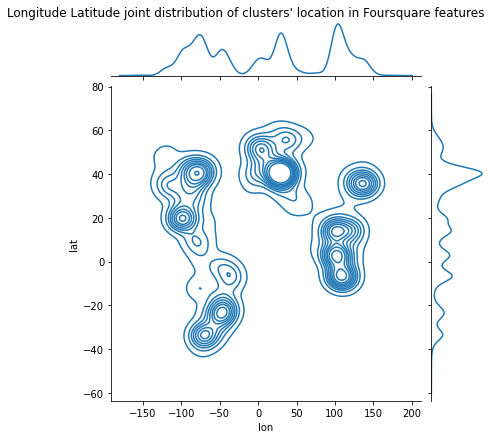

In [13]:
sns.jointplot(data = df_training, y = 'lat', x = 'lon', kind="kde")
plt.title('Longitude Latitude joint distribution of clusters\' location in Foursquare features',\
          loc='right',pad=70)
plt.show()

We can see that Foursquare features are distributed over all the world with a high concentration in northen american, european and austrialian continents.

## 3.2. Gowalla and Brighkite Features
- We now do the same work with the original datasets we were provided : the gowalla dataset and the brightkite dataset.

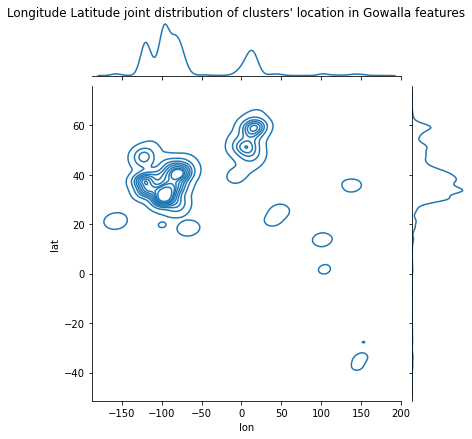

In [14]:
sns.jointplot(data = df_gowalla_features, y = 'lat', x = 'lon', kind="kde")
plt.title('Longitude Latitude joint distribution of clusters\' location in Gowalla features',\
          loc='right',pad=70)
plt.show()

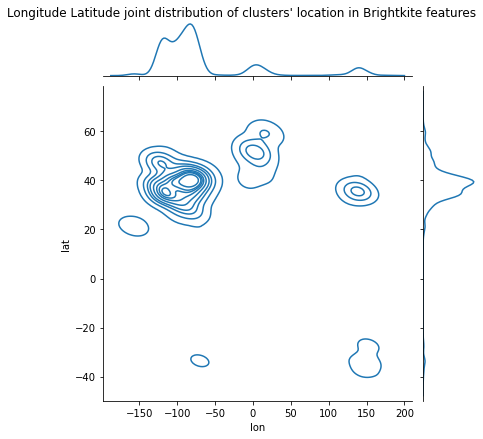

In [15]:
sns.jointplot(data = df_brightkite_features, y = 'lat', x = 'lon', kind="kde")
plt.title('Longitude Latitude joint distribution of clusters\' location in Brightkite features',\
          loc='right',pad=70)
plt.show()

- Here, we can clearly see the features' locations for both Gowalla and Brightkite datasets are concentrated in northen america and more precisely in the US.  
- In order to have the best accuracy possible in our predictions, we train our model only on the USA : We filter the foursquare dataset in order to only keep USA. This will help us get the best possible predictions in our test datasets.

# 4. Home Location Prediction:

## 4.1. Whole dataset:

### 4.1.1. Splitting Data:
- As stated before, we choose to train our models only over USA

In [18]:
def splitting_data(df_training, country = None, upsampling = True, standerdize = True ):
    """
    function to split our data into a training set, a validation set and a test set
    Inputs:
        - df_training:dataset used for training
        - country : string : specify the abbreviation of countries : 2 Maj letters
                    if set to None : take the whole dataset
        - upsampling : choose to upsample the trainig set or not
        - standerdize : standardise the dataset (features only not the result)
        
    Outputs:
        - X_train : training features
        - y_train : training results
        - X_val : validation features
        - y_val : validation results
        - X_test : test features
        - y_test : test results
        - scaler : scaler that was used to normalize data
    """
    if country:
        df_training = df_training.loc[df_training.country == country]
    
    #test dataframe : 10% of the whole dataframe
    df_test = df_training.sample(frac = 0.1)
    df_training = df_training[~df_training.index.isin(df_test.index)]
    
    #X,y are the training data , X : features, y :results
    X=df_training[['CR','MR','EDR','EIDR','PR','RPR']].values
    y=df_training['Is_home'].values
    
    #set scaler and standaridize data if the user wants to
    if standerdize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        scaler = None
    
    #generate new features if the user wants to upsample
    if upsampling:
        oversample = SMOTE()
        X, y = oversample.fit_resample(X, y)
    
    #split data into validation and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    
    #get test sets
    X_test = df_test[['CR','MR','EDR','EIDR','PR','RPR']].values
    y_test = df_test['Is_home'].values
    
    #scale the test features the same way that was done for the training and validation ones
    X_test = scaler.transform(X_test)
    
    return X_train, y_train, X_val, y_val, X_test, y_test, scaler

In [19]:
X_train, y_train, X_val, y_val, X_test, y_test, scaler = splitting_data(df_training)

### 4.1.2. Training Support Vector Machine Classifier (SVM classifier)

In [20]:
clf_svc = SVC(kernel='linear',verbose=True,class_weight='balanced')
clf_svc.fit(X_train, y_train)

[LibSVM]

SVC(class_weight='balanced', kernel='linear', verbose=True)

In [22]:
joblib.dump(clf_svc, 'models/SVC_all.pkl')

['models/SVC_all.pkl']

In [23]:
y_pred = clf_svc.predict(X_test) > 0.5

In [24]:
print('with this SVM Classifier model, we find and f1 score of {} on the test set'.\
      format(f1_score(y_test,y_pred)))

0.6503620273531778

### 4.1.3. Training a Neural Network Classifier

#### 4.1.3.1. Define f1 metric

In [25]:
#compute recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

#compute precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#compute F1-score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### 4.1.3.2. Define NN Model

In [27]:
model = Sequential([
    Dense(60, input_shape = (X_train.shape[1],), activation='relu'),
    Dropout(0.5),
    Dense(40, activation = 'relu'),
    Dropout(0.5),
    Dense(30, activation = 'relu'),
    Dropout(0.5),
    Dense(30, activation = 'relu'),
    Dropout(0.5),
    Dense(10, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[f1_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                420       
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2440      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1230      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                9

In [28]:
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=20,batch_size=10)

Epoch 1/20
20763/20763 [==============================] - 52s 2ms/step - loss: 0.4851 - f1_m: 0.7637 - val_loss: 0.3826 - val_f1_m: 0.8299
Epoch 2/20
20763/20763 [==============================] - 47s 2ms/step - loss: 0.4355 - f1_m: 0.8088 - val_loss: 0.3849 - val_f1_m: 0.8315
Epoch 3/20
20763/20763 [==============================] - 49s 2ms/step - loss: 0.4384 - f1_m: 0.8131 - val_loss: 0.3941 - val_f1_m: 0.8301
Epoch 4/20
20763/20763 [==============================] - 48s 2ms/step - loss: 0.4339 - f1_m: 0.8120 - val_loss: 0.4057 - val_f1_m: 0.8300
Epoch 5/20
20763/20763 [==============================] - 47s 2ms/step - loss: 0.4332 - f1_m: 0.8146 - val_loss: 0.3912 - val_f1_m: 0.8336
Epoch 6/20
20763/20763 [==============================] - 51s 2ms/step - loss: 0.4310 - f1_m: 0.8140 - val_loss: 0.3938 - val_f1_m: 0.8333
Epoch 7/20
20763/20763 [==============================] - 51s 2ms/step - loss: 0.4318 - f1_m: 0.8143 - val_loss: 0.4391 - val_f1_m: 0.8328
Epoch 8/20
20763/20763 [===

KeyboardInterrupt: 

In [ ]:
model.save('models/NN_clf_all')

In [ ]:
y_pred_NN=model.predict(X_test)

In [ ]:
y_pred =y_pred_NN.flatten() > 0.5

In [ ]:
print('with this Neural network model, we find and f1 score of {} on the test set'.\
      format(f1_score(y_test,y_pred)))

In [ ]:
y_pred.astype(int)

### 4.1.3. Random forest classifier:

In [ ]:
clf_RF = RandomForestClassifier(n_estimators= 20, max_depth=None, random_state=0,criterion='entropy',
                             class_weight='balanced', verbose=True)

In [ ]:
clf_RF.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print('with this Random forest model, we find and f1 score of {} on the test set'.\
      format(f1_score(y_test,y_pred)))

In [ ]:
joblib.dump(clf_RF, 'models/RF_all.pkl')

In [ ]:
scaler

In [ ]:
joblib.dump(scaler,'models/scaler_all.pkl')

## 4.2. Only USA:
- We do the same work we did previously but working only with USA
- We will use the variables used before in order to preserve memory

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, scaler = splitting_data(df_training, country='US')

### 4.2.2. Training Support Vector Machine Classifier (SVM classifier)

In [ ]:
#Since we have less data, we can use a degree 3 SVM
clf_svc = SVC(kernel='poly',degree=3,verbose=True,class_weight='balanced')
clf_svc.fit(X_train, y_train)

In [ ]:
joblib.dump(clf_svc, 'models/SVC_USA.pkl')

In [ ]:
y_pred = clf_svc.predict(X_test) > 0.5

In [ ]:
print('with this SVM Classifier model, we find and f1 score of {} on the test set'.\
      format(f1_score(y_test,y_pred)))

### 4.2.3. Training a Neural Network Classifier

The f1 metric stays the same, the architecture of the Neural Network too

In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=20,batch_size=10)

In [ ]:
model.save('models/NN_clf_USA')

In [ ]:
y_pred_NN=model.predict(X_test)

In [ ]:
y_pred =y_pred_NN.flatten() > 0.5

In [ ]:
print('with this Neural network model, we find and f1 score of {} on the test set'.\
      format(f1_score(y_test,y_pred)))

In [ ]:
y_pred.astype(int)

### 4.2.3. Random forest classifier:

In [ ]:
clf_RF = RandomForestClassifier(n_estimators= 20, max_depth=None, random_state=0,criterion='entropy',
                             class_weight='balanced', verbose=True)

In [ ]:
clf_RF.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print('with this Random forest model, we find and f1 score of {} on the test set'.\
      format(f1_score(y_test,y_pred)))

In [ ]:
joblib.dump(clf_RF, 'models/RF_USA.pkl')

In [ ]:
scaler

In [ ]:
joblib.dump(scaler,'models/scaler_all.pkl')